In [1]:
#Copy the code and change the name for other artists
artist_name = "Billie Eilish"

In [2]:
import pandas as pd
import codecs
import json
from pandas.io.json import json_normalize
import re

In [3]:
#Machine learning libraries for Text analysis
import nltk  # machine learning with text
from nltk import download as nltk_download
from nltk.corpus import stopwords, wordnet  # List of common words
from nltk.tokenize import word_tokenize  # Split text into significant forms
from nltk.stem import WordNetLemmatizer  # Reduce words to their root form
from nltk import pos_tag  # Tag words with parts of speech
from collections import defaultdict, Counter  # Dictionaries that have a backup value
from sklearn.feature_extraction.text import CountVectorizer  # Convert text to sparse matrices
from textblob import TextBlob  # Sentiment analysis
from gensim.models.ldamodel import LdaModel  # Topic extraction
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS  # ngrams
from gensim.models.phrases import Phraser  # ngrams
from gensim import corpora, models, similarities  # Vectorization
import pyLDAvis
from wordcloud import WordCloud  # Create wordclouds
import matplotlib.pylab as plt

# Run next 2 cells only if you want to pull data from Genius

In [ ]:
from lyricsgenius import Genius

genius = Genius('JOSfSO0Cn0Y3avlw_ItRLdmwFj3s-36fjS-POUolMGFiWkUiE_zHXfQZVsOOqbxA', timeout=10)
artist = genius.search_artist(artist_name, max_songs = 300) # use max_songs=10 parameter to limit to 10 songs

In [ ]:
artist_json = artist.save_lyrics()

# Start here to use the data from the file on disk

In [4]:
#load the file
name_string = artist_name.replace(' ', '')
lyricsFile = "Lyrics_"+str(name_string)+".json"
with open(lyricsFile) as json_data:
    data = json.load(json_data)

# convert to dataframe
df = pd.DataFrame(data['songs'])
artist_df = df[['full_title', 'title', 'artist', 'lyrics', 'featured_artists', 'release_date']]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Lyric Analysis

## Cleaning the lyrics

In [5]:
# convert everything to lower case
artist_df.lyrics = artist_df.lyrics.str.lower()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [6]:
artist_df.lyrics[2]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


"[verse 1]\nwhite shirt now red, my bloody nose\nsleepin', you're on your tippy toes\ncreepin' around like no one knows\nthink you're so criminal\nbruises on both my knees for you\ndon't say thank you or please\ni do what i want when i'm wanting to\nmy soul? so cynical\n\n[chorus]\nso you're a tough guy\nlike it really rough guy\njust can't get enough guy\nchest always so puffed guy\ni'm that bad type\nmake your mama sad type\nmake your girlfriend mad tight\nmight seduce your dad type\ni'm the bad guy\nduh\n\n[post-chorus]\ni'm the bad guy\n\n[verse 2]\ni like it when you take control\neven if you know that you don't\nown me, i'll let you play the role\ni'll be your animal\nmy mommy likes to sing along with me\nbut she won't sing this song\nif she reads all the lyrics\nshe'll pity the men i know\n[chorus]\nso you're a tough guy\nlike it really rough guy\njust can't get enough guy\nchest always so puffed guy\ni'm that bad type\nmake your mama sad type\nmake your girlfriend mad tight\nmi

In [7]:
# remove the embed, share, copy at the end of each lyric
artist_df.lyrics = artist_df.lyrics.replace(to_replace="embedshare url:copyembed:copy", value="", regex=True) 

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
# Remove quotes
artist_df.lyrics = artist_df.lyrics.replace(to_replace="(\u2019)", value="'", regex=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
# convert common contractions to the full word or phrase
artist_df.lyrics = artist_df.lyrics.replace(to_replace="won't", value="will not", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="wouldn't", value="wouldnt", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="can't", value="cannot", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="don't", value="dont", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="wanna", value="want to", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="ain't", value="aint", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="gotta", value="got to", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="'ll", value=" will", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="lil'", value="little", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="hol'", value="hold", regex=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
# convert more common contractions to the full word or phrase
artist_df.lyrics = artist_df.lyrics.replace(to_replace="it's", value="it is", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="i've", value="i have", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="i'm", value="i am", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="i'd", value="i would", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="you're", value="you are", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="n' ", value="ng ", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="'s ", value="s ", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="'n ", value="ing ", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace=" 'em ", value="them ", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace="&", value="and", regex=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [11]:
# Remove common interjections, or singing sounds
artist_df.lyrics = artist_df.lyrics.replace(to_replace=r"aah|aagh|ayy|ooh|da|ahh", value="", regex=True) 
artist_df.lyrics = artist_df.lyrics.replace(to_replace=r"hmm|mmm|brr", value="", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace=r"yeah", value="", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace=r"woah", value="", regex=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
# remove verse, chorus, bridge, intro , outro anotations 
artist_df.lyrics = artist_df.lyrics.replace(to_replace=r"\[[^]]*\]", value="", regex=True) 

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [13]:
# get rid of tabs, new line, return symbols and parentheses
artist_df.lyrics = artist_df.lyrics.replace(to_replace=[r"\\t|\\n|\\r", "\t|\n|\r"], value=" ", regex=True)
artist_df.lyrics = artist_df.lyrics.replace(to_replace=[r"\(|\)", ""], value=" ", regex=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
artist_df.lyrics[2]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


" white shirt now red, my bloody nose sleepin', you are on your tippy toes creeping around like no one knows think you are so criminal bruises on both my knees for you dont say thank you or please i do what i want when i am wanting to my soul? so cynical   so you are a tough guy like it really rough guy just cannot get enough guy chest always so puffed guy i am that bad type make your mama sad type make your girlfriend mad tight might seduce your d type i am the bad guy duh   i am the bad guy   i like it when you take control even if you know that you dont own me, i will let you play the role i will be your animal my mommy likes to sing along with me but she will not sing this song if she reads all the lyrics she will pity the men i know  so you are a tough guy like it really rough guy just cannot get enough guy chest always so puffed guy i am that bad type make your mama sad type make your girlfriend mad tight might seduce your d type i am the bad guy duh   i am the bad guy, duh i am 

In [15]:
# remove any other symbols except letters, numbers and underscore
artist_df.lyrics = artist_df.lyrics.replace(to_replace=r"\W", value=" ", regex=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
artist_df.lyrics[2]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


' white shirt now red  my bloody nose sleepin   you are on your tippy toes creeping around like no one knows think you are so criminal bruises on both my knees for you dont say thank you or please i do what i want when i am wanting to my soul  so cynical   so you are a tough guy like it really rough guy just cannot get enough guy chest always so puffed guy i am that bad type make your mama sad type make your girlfriend mad tight might seduce your d type i am the bad guy duh   i am the bad guy   i like it when you take control even if you know that you dont own me  i will let you play the role i will be your animal my mommy likes to sing along with me but she will not sing this song if she reads all the lyrics she will pity the men i know  so you are a tough guy like it really rough guy just cannot get enough guy chest always so puffed guy i am that bad type make your mama sad type make your girlfriend mad tight might seduce your d type i am the bad guy duh   i am the bad guy  duh i am 

In [17]:
artist_df_clean = artist_df

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [18]:
# Tokenize
artist_df.lyrics = artist_df.lyrics.apply(word_tokenize)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
artist_df.lyrics[2]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['white',
 'shirt',
 'now',
 'red',
 'my',
 'bloody',
 'nose',
 'sleepin',
 'you',
 'are',
 'on',
 'your',
 'tippy',
 'toes',
 'creeping',
 'around',
 'like',
 'no',
 'one',
 'knows',
 'think',
 'you',
 'are',
 'so',
 'criminal',
 'bruises',
 'on',
 'both',
 'my',
 'knees',
 'for',
 'you',
 'dont',
 'say',
 'thank',
 'you',
 'or',
 'please',
 'i',
 'do',
 'what',
 'i',
 'want',
 'when',
 'i',
 'am',
 'wanting',
 'to',
 'my',
 'soul',
 'so',
 'cynical',
 'so',
 'you',
 'are',
 'a',
 'tough',
 'guy',
 'like',
 'it',
 'really',
 'rough',
 'guy',
 'just',
 'can',
 'not',
 'get',
 'enough',
 'guy',
 'chest',
 'always',
 'so',
 'puffed',
 'guy',
 'i',
 'am',
 'that',
 'bad',
 'type',
 'make',
 'your',
 'mama',
 'sad',
 'type',
 'make',
 'your',
 'girlfriend',
 'mad',
 'tight',
 'might',
 'seduce',
 'your',
 'd',
 'type',
 'i',
 'am',
 'the',
 'bad',
 'guy',
 'duh',
 'i',
 'am',
 'the',
 'bad',
 'guy',
 'i',
 'like',
 'it',
 'when',
 'you',
 'take',
 'control',
 'even',
 'if',
 'you',
 'know'

## Analysis: common 2 and 3 word phrases found in the lyrics

In [20]:
# Divide the lyrics into "sentences" so that the phrases don't straddle songs.   Each song = one sentence
sentences = []
for l in artist_df.lyrics:
    sentences.append(l)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
# Number of sentences should equal the number of songs
len(sentences)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


153

In [22]:
# check our result on the first sentence
sentences[0]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['dont',
 'you',
 'know',
 'i',
 'am',
 'no',
 'good',
 'for',
 'you',
 'i',
 'have',
 'learned',
 'to',
 'lose',
 'you',
 'can',
 'not',
 'afford',
 'to',
 'tore',
 'my',
 'shirt',
 'to',
 'stop',
 'you',
 'bleedin',
 'but',
 'nothing',
 'ever',
 'stops',
 'you',
 'leavin',
 'quiet',
 'when',
 'i',
 'am',
 'coming',
 'home',
 'and',
 'i',
 'am',
 'on',
 'my',
 'own',
 'i',
 'could',
 'lie',
 'say',
 'i',
 'like',
 'it',
 'like',
 'that',
 'like',
 'it',
 'like',
 'that',
 'i',
 'could',
 'lie',
 'say',
 'i',
 'like',
 'it',
 'like',
 'that',
 'like',
 'it',
 'like',
 'that',
 'dont',
 'you',
 'know',
 'too',
 'much',
 'already',
 'i',
 'will',
 'only',
 'hurt',
 'you',
 'if',
 'you',
 'let',
 'me',
 'call',
 'me',
 'friend',
 'but',
 'keep',
 'me',
 'closer',
 'call',
 'me',
 'back',
 'and',
 'i',
 'will',
 'call',
 'you',
 'when',
 'the',
 'partys',
 'over',
 'quiet',
 'when',
 'i',
 'am',
 'coming',
 'home',
 'and',
 'i',
 'am',
 'on',
 'my',
 'own',
 'and',
 'i',
 'could',
 'lie',


In [23]:
# Look for frequently used 2 word combinations
from itertools import groupby

# Build the bigram model
bigram = Phrases(sentences)


# Find bigrams in the songs
two_word_phrases = []
i=0
while i < len(sentences): 
    bigrams = bigram[sentences[i]]
    for s in bigrams:
        if len(re.findall('_', s)) > 0:
            two_word_phrases.append(s)
    i = i + 1
two_word_phrases_df = pd.DataFrame(two_word_phrases, columns = ['Phrases'])
test = two_word_phrases_df.groupby(by = "Phrases").size().reset_index(name='counts')
test.sort_values(by = 'counts', ascending = False).head()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Phrases,counts
45,can_not,166
228,those_ocean,103
174,one_by,80
172,ocean_eyes,72
157,my_boy,71


In [24]:
# Looking for 3 word combinations 

# Build the trigram models
trigram = Phrases(bigram[sentences])

tri = []

# Construct trigram list looking at all songs
i=0
while i < len(sentences): 
    songtrigram = trigram[bigram[sentences[i]]]
    for s in songtrigram:
        if len(re.findall('_', s)) > 1:
            tri.append(s)
    i = i + 1

tri_df = pd.DataFrame(tri, columns = ['Phrases'])
test_tri = tri_df.groupby(by = "Phrases").size().reset_index(name='counts')
test_tri.sort_values(by = 'counts', ascending = False).head(30)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Phrases,counts
140,those_ocean_eyes,67
118,really_know_how,44
91,make_me_cry,41
72,have_never_fallen_from,36
117,quite_this_high_falling,36
80,into_your_ocean_eyes,35
123,should_see_me,29
129,started_in_me,28
141,those_ocean_eyes_no,25
93,maybe_it_is,24


In [25]:
fourgram = Phrases(trigram[sentences])
four = []

# Construct trigram list looking at all songs
i=0
while i < len(sentences): 
    songtrigram = fourgram[trigram[sentences[i]]]
    for s in songtrigram:
        if len(re.findall('_', s)) > 2:
            four.append(s)
    i = i + 1
    
four_df = pd.DataFrame(four, columns = ['Phrases'])
test_four = four_df.groupby(by = "Phrases").size().reset_index(name='counts')
test_four.sort_values(by = 'counts', ascending = False).head(20)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,Phrases,counts
17,give_me_those_ocean,40
23,high_falling_into_your,36
22,have_never_fallen_from,36
34,ocean_eyes_those_ocean,35
7,can_not_help_but,24
9,can_not_watch_mine,22
30,my_boy_my_boy,21
35,one_by_one_by,20
8,can_not_say_no,20
49,would_feel_better_but,18


In [26]:
len(set(tri))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


170

In [27]:
from gensim.models.phrases import Phrases, Phraser

phrases = Phrases(sentences, min_count=5, threshold=10, connector_words=ENGLISH_CONNECTOR_WORDS)
phrases_df = pd.DataFrame(columns = ['phrase', 'score'])
phrase_col = []
score_col = []
wordcount_col = []
for phrase, score in phrases.find_phrases(sentences).items():
    phrase_col.append(phrase)
    score_col.append(score)
    wordcount_col.append(len(re.findall('_', phrase)) + 1)   
phrases_df['phrase'] = phrase_col
phrases_df['score'] = score_col
phrases_df['wordcount'] = wordcount_col
phrases_df[phrases_df['wordcount'] > 2].sort_values(by='score', ascending = False).head(50)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,phrase,score,wordcount
57,cities_and_napalm,427.729592,3
253,killing_the_son,390.839161,3
35,step_on_the_glass,330.710059,4
22,filled_by_models,258.750000,3
122,belong_to_anyone,211.704545,3
67,fallen_from_quite,211.085526,3
158,ball_and_chain,190.102041,3
114,finger_on_the_trigger,190.102041,4
197,door_and_leave,153.333333,3
148,burn_with_the_fire,142.450133,4


In [28]:
from nltk import ngrams
tgs = nltk.ngrams(sentences[0],5)
fdist = nltk.FreqDist(tgs)
d = Counter()
ngrams_df = pd.DataFrame(columns = ['N-gram', 'Count'])
ngrams_col = []
Count_col = []
for k, v in fdist.items():
    d[k] = v
    ngrams_col.append(k)
    Count_col.append(v)
ngrams_df['N-gram'] = ngrams_col
ngrams_df['Count'] = Count_col
ngrams_df.sort_values(by='Count', ascending = False).head(10)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,N-gram,Count
44,"(i, could, lie, say, i)",6
45,"(could, lie, say, i, like)",6
52,"(that, like, it, like, that)",6
51,"(like, that, like, it, like)",6
50,"(it, like, that, like, it)",6
49,"(like, it, like, that, like)",6
48,"(i, like, it, like, that)",6
47,"(say, i, like, it, like)",6
46,"(lie, say, i, like, it)",6
37,"(home, and, i, am, on)",3


In [29]:
artist_df.lyrics

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0      [dont, you, know, i, am, no, good, for, you, i...
1      [i, had, a, dream, i, got, everything, i, want...
2      [white, shirt, now, red, my, bloody, nose, sle...
3      [dont, be, that, way, fall, apart, twice, a, y...
4      [billie, what, do, you, want, from, me, why, d...
                             ...                        
148    [oh, boy, we, bout, to, bomb, the, next, one, ...
149    [north, americafebruary, february, 3, 2022, ne...
150    [somethings, in, the, air, right, now, like, i...
151    [من, دوست, شما, نیستم, یا, هر, چیز, دیگری, لعن...
152    [ورس۱, کمک, من, خودم, را, دوباره, گم, کردم, ام...
Name: lyrics, Length: 153, dtype: object

In [30]:
stop_words = stopwords.words("english")
artist_df.lyrics = artist_df.lyrics.apply(lambda x: [y for y in x if y not in stop_words])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [31]:
artist_df.lyrics

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0      [dont, know, good, learned, lose, afford, tore...
1      [dream, got, everything, wanted, think, honest...
2      [white, shirt, red, bloody, nose, sleepin, tip...
3      [dont, way, fall, apart, twice, wish, could, f...
4      [billie, want, dont, run, wondering, know, sca...
                             ...                        
148    [oh, boy, bout, bomb, next, one, oh, oh, alrig...
149    [north, americafebruary, february, 3, 2022, ne...
150    [somethings, air, right, like, losing, track, ...
151    [من, دوست, شما, نیستم, یا, هر, چیز, دیگری, لعن...
152    [ورس۱, کمک, من, خودم, را, دوباره, گم, کردم, ام...
Name: lyrics, Length: 153, dtype: object

In [32]:
lemma = WordNetLemmatizer()

# Dictionary to convert between part-of-speech tags and the ones the lemmatizer understands

tag_dict = defaultdict(lambda : wordnet.NOUN)
tag_dict['J'] = wordnet.ADJ
tag_dict['V'] = wordnet.VERB
tag_dict['R'] = wordnet.ADV

# function to lemmatize a sentence

def get_lemma(word):
    """Gets the POS tag for a word, and then returns the lemmatized form of the word"""
    tag = pos_tag([word])[0][1][0]
    tag = tag_dict[tag]
    
    return lemma.lemmatize(word, tag)

# Perform the lemmatization
#artist_df.lyrics = artist_df.lyrics.apply(lambda x: [get_lemma(word) for word in x])#
artist_df.lyrics = artist_df.lyrics.apply(lambda x: [get_lemma(word) for word in x])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [33]:
remove_words = ['like', 'get', 'got', 'know', 'say', 'dont']
artist_df.lyrics = artist_df.lyrics.apply(lambda x: [y for y in x if y not in remove_words])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
artist_df.lyrics[0]

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['good',
 'learn',
 'lose',
 'afford',
 'tore',
 'shirt',
 'stop',
 'bleedin',
 'nothing',
 'ever',
 'stop',
 'leavin',
 'quiet',
 'come',
 'home',
 'could',
 'lie',
 'could',
 'lie',
 'much',
 'already',
 'hurt',
 'let',
 'call',
 'friend',
 'keep',
 'closer',
 'call',
 'back',
 'call',
 'party',
 'quiet',
 'come',
 'home',
 'could',
 'lie',
 'could',
 'lie',
 'nothing',
 'well',
 'sometimes',
 'goodbye',
 'let',
 'let',
 'go',
 'let',
 'let',
 'go',
 'quiet',
 'come',
 'home',
 'could',
 'lie',
 'could',
 'lie']

In [35]:
# Create the list of words and their frequency (corpus)
from gensim import corpora
pyLDAvis.enable_notebook()
#dictionary = corpora.Dictionary(artist_df.lyrics )
dictionary = corpora.Dictionary(artist_df.lyrics)
corpus = [dictionary.doc2bow(text) for text in artist_df.lyrics ]

import pickle
pickle.dump(corpus, open('corpus.pkl', 'wb'))
dictionary.save('dictionary.gensim')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [36]:
import gensim
NUM_TOPICS = 4
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
ldamodel.save('model3.gensim')
topics = ldamodel.print_topics(num_words=10)
for topic in topics:
    print(topic)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(0, '0.056*"eye" + 0.046*"ocean" + 0.026*"never" + 0.023*"give" + 0.021*"fall" + 0.019*"watch" + 0.018*"make" + 0.016*"back" + 0.015*"cry" + 0.013*"fair"')
(1, '0.035*"want" + 0.032*"one" + 0.022*"boy" + 0.016*"love" + 0.014*"need" + 0.013*"mind" + 0.012*"see" + 0.011*"friend" + 0.009*"end" + 0.009*"wheres"')
(2, '0.018*"want" + 0.015*"think" + 0.014*"cause" + 0.014*"sorry" + 0.013*"mine" + 0.013*"guy" + 0.012*"na" + 0.012*"make" + 0.010*"watch" + 0.010*"go"')
(3, '0.022*"could" + 0.019*"would" + 0.016*"young" + 0.013*"want" + 0.013*"من" + 0.013*"love" + 0.012*"dumb" + 0.012*"شما" + 0.011*"lie" + 0.011*"let"')


In [37]:
import pyLDAvis.gensim_models
lda_display = pyLDAvis.gensim_models.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(lda_display)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [38]:
dictionary

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [39]:
from gensim.test.utils import datapath
from gensim.models.word2vec import Text8Corpus
from gensim.models.phrases import Phrases, Phraser

#sentences = Text8Corpus(datapath('testcorpus.txt'))
artist_df.lyrics1 = [wd for wd in artist_df.lyrics]

# Build the bigram models
bigram = gensim.models.phrases.Phrases(artist_df.lyrics1, min_count=3, threshold=10)

# Construct bigram
print(bigram[artist_df.lyrics[0]])

['good', 'learn', 'lose', 'afford', 'tore', 'shirt', 'stop', 'bleedin', 'nothing', 'ever', 'stop', 'leavin', 'quiet_come', 'home_could', 'lie', 'could_lie', 'much', 'already', 'hurt', 'let', 'call', 'friend', 'keep', 'closer', 'call', 'back', 'call', 'party', 'quiet_come', 'home_could', 'lie', 'could_lie', 'nothing', 'well', 'sometimes', 'goodbye', 'let', 'let', 'go', 'let', 'let', 'go', 'quiet_come', 'home_could', 'lie', 'could_lie']


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-39-00f6d1d42edf>:6: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  artist_df.lyrics1 = [wd for wd in artist_df.lyrics]


# Wordcloud

In [40]:
artist_df.lyrics = artist_df.lyrics.apply(lambda x: " ".join(x))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [41]:
artist_df.head()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,full_title,title,artist,lyrics,featured_artists,release_date
0,​when the party's over by Billie Eilish,​when the party’s over,Billie Eilish,good learn lose afford tore shirt stop bleedin...,[],2018-10-17
1,​everything i wanted by Billie Eilish,​everything i wanted,Billie Eilish,dream everything want think honest might night...,[],2019-11-13
2,​bad guy by Billie Eilish,​bad guy,Billie Eilish,white shirt red bloody nose sleepin tippy toe ...,[],2019-03-29
3,​idontwannabeyouanymore by Billie Eilish,​idontwannabeyouanymore,Billie Eilish,way fall apart twice wish could feel show neve...,[],2017-07-21
4,​bury a friend by Billie Eilish,​bury a friend,Billie Eilish,billie want run wonder scar care fall asleep g...,[],2019-01-30


In [42]:
# Create an object that converts strings into a sparse matrix
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features= 20000 , min_df=0.01, ngram_range= (1,1))

# Convert the text column to a sparse matrix

data_dtm = vectorizer.fit_transform(artist_df.lyrics)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [43]:
# Create a dataframe of terms and frequencies
# Get the frequency of each term

term_frequencies = data_dtm.sum(axis=0)

# Match frequencies to terms

frequent_terms = [(word, term_frequencies[0, id]) for word, id in vectorizer.vocabulary_.items()]

# Convert the word-frequency pairings to a dataframe

term_df = pd.DataFrame(columns=["term","frequency"], data=frequent_terms)

# Sort the dataframe

term_df.sort_values(by="frequency", ascending=False, inplace=True)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [44]:
term_df.head(20)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,term,frequency
32,want,280
222,eye,218
160,love,186
315,ocean,181
110,make,178
55,one,166
314,watch,147
29,go,139
146,never,137
233,give,136


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


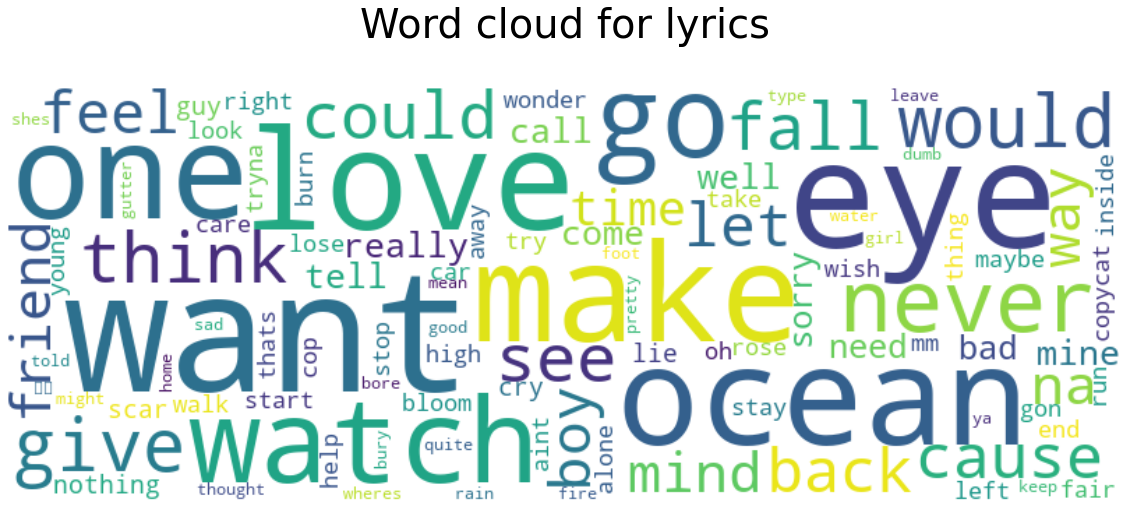

In [45]:
# Create a dictionary of most frequent terms ((required for word clouds)

term_dict = term_df.set_index('term')['frequency'].to_dict()

# Create a wordcloud of most frequent terms

wc = WordCloud(width=800, height=300, background_color="white",
               max_words=100)

wc.generate_from_frequencies(term_dict)

# Display the cloud

plt.figure(figsize=(20, 10))
plt.title("Word cloud for lyrics", fontsize = 40, pad = 50 )
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

# Sentiment

In [46]:
# Assign sentiment to each lyric
artist_df["sentiment"] = artist_df.lyrics.apply(lambda x: TextBlob(x).sentiment.polarity)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-46-d312c35c4e1f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  artist_df["sentiment"] = artist_df.lyrics.apply(lambda x: TextBlob(x).sentiment.polarity)


In [47]:
artist_df.sort_values(by="sentiment", ascending=True).head(10)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,full_title,title,artist,lyrics,featured_artists,release_date,sentiment
128,Billie Bossa Nova pt 2 by Billie Eilish,Billie Bossa Nova pt 2,Billie Eilish,jk pranked idiot,[],2021-05-12,-0.800000
66,Getting Older by Billie Eilish,Getting Older,Billie Eilish,decision abuse trauma thing want afraid tell y...,[],2021-07-30,-0.600000
51,​daddy* by Billie Eilish (Ft. MadeinTYO),​daddy*,Billie Eilish,make sad boy well look who sad ddy givenchy ki...,"[{'api_path': '/artists/346237', 'header_image...",None,-0.500000
84,Stoned by Billie Eilish,Stoned,Billie Eilish,want nce little girl shadow see thing hid burn...,[],None,-0.393750
2,​bad guy by Billie Eilish,​bad guy,Billie Eilish,white shirt red bloody nose sleepin tippy toe ...,[],2019-03-29,-0.368061
131,Bad guy (Topic Remix) by Billie Eilish (Ft. To...,Bad guy (Topic Remix),Billie Eilish,white shirt red bloody nose sleepin tippy toe ...,"[{'api_path': '/artists/18954', 'header_image_...",None,-0.368061
75,​bad guy (Demo) by Billie Eilish,​bad guy (Demo),Billie Eilish,white shirt red bloody nose sleepin tippy toe ...,[],None,-0.363478
142,​bad guy (Live at Third Man Records) by Billie...,​bad guy (Live at Third Man Records),Billie Eilish,must song white shirt red bloody nose sleepin ...,[],2019-12-06,-0.314874
65,COPYCAT (Sofi Tukker Remix) by Billie Eilish,COPYCAT (Sofi Tukker Remix),Billie Eilish,copycat try cop manner watch back watch mine c...,[],2018-01-12,-0.252381
44,​another stupid song* by Billie Eilish,​another stupid song*,Billie Eilish,miss oh well never even kiss without countdown...,[],None,-0.245455


In [48]:
artist_df.describe()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,sentiment
count,153.000000
mean,0.085237
std,0.235495
min,-0.800000
25%,-0.046429
50%,0.100000
75%,0.224167
max,0.700000


In [49]:
artist_df['Datetime'] = pd.to_datetime(df['release_date'], format="%Y/%m/%d")
artist_df = artist_df.sort_values(by = "Datetime")

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-49-20a3b369a7a7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  artist_df['Datetime'] = pd.to_datetime(df['release_date'], format="%Y/%m/%d")


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


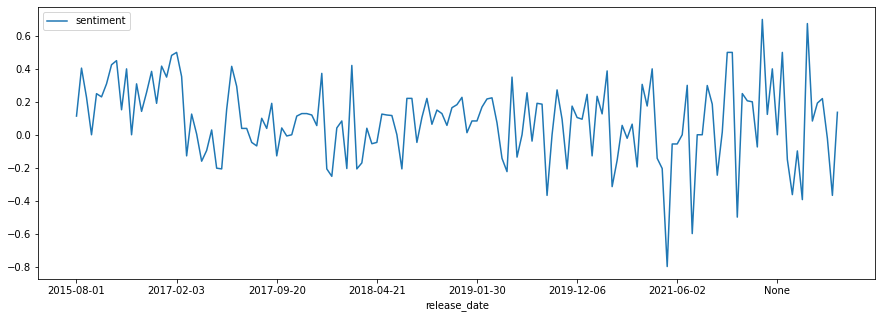

In [50]:
plt = artist_df.plot(x = 'release_date', y = 'sentiment', figsize=(15, 5))